# NLP Clase 4 - Sábado 28/11/2020

In [ ]:
!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip

--2020-11-28 15:31:10--  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.twitter.27B.zip [following]
--2020-11-28 15:31:10--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2020-11-28 15:31:11--  http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [appli

In [ ]:
!unzip glove.twitter.27B.zip

Archive:  glove.twitter.27B.zip
  inflating: glove.twitter.27B.25d.txt  
  inflating: glove.twitter.27B.50d.txt  
  inflating: glove.twitter.27B.100d.txt  
  inflating: glove.twitter.27B.200d.txt  


In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz

--2020-11-28 15:44:47--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1325960915 (1.2G) [binary/octet-stream]
Saving to: ‘cc.en.300.vec.gz’

cc.en.300.vec.gz    100%[===================>]   1.23G  13.5MB/s    in 95s     

2020-11-28 15:46:23 (13.3 MB/s) - ‘cc.en.300.vec.gz’ saved [1325960915/1325960915]



In [ ]:
!gunzip -k cc.en.300.vec.gzy

gzip: cc.en.300.vec already exists; do you wish to overwrite (y or n)? n
	not overwritten


Código de ejemplo de: https://github.com/ejesposito/ceai/blob/master/nlp/word2vec/pretrained.py

In [1]:
import logging

import os
from pathlib import Path
from io import StringIO
import pickle

from pathlib import Path
from io import StringIO
import pickle

import numpy as np


logging.basicConfig(level=logging.INFO)

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):

    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60


class FasttextEmbeddings(WordsEmbeddings):

    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [2]:
model_ft = FasttextEmbeddings()
print(model_ft.get_words_embeddings(['hi', 'hello']))

[[ 6.6910e-01  3.1210e-01 -1.5140e-01 -5.3600e-02  1.7220e-01  1.0390e-01
  -1.9930e-01  1.1110e-01 -3.8200e-02  1.2510e-01 -3.7600e-02 -9.1000e-02
  -1.4160e-01 -4.0000e-04  5.7390e-01  7.8800e-02 -1.3200e-02 -1.5620e-01
  -4.4630e-01  1.1750e-01 -1.2190e-01  6.9600e-02 -8.0100e-02 -1.5760e-01
   3.7380e-01  4.7000e-03 -7.7000e-02 -7.4800e-02 -3.6340e-01  8.6050e-01
  -5.5620e-01 -1.2960e-01  8.7000e-02 -4.5000e-03 -1.3830e-01 -3.3000e-02
   1.7280e-01  1.1010e-01 -3.8300e-01  5.2400e-02 -2.8600e-02 -2.7010e-01
  -3.1550e-01  3.6300e-01  2.4820e-01  2.0150e-01 -7.8500e-02  2.8210e-01
  -1.5350e-01  2.5260e-01  2.0630e-01 -3.7370e-01  4.6010e-01  4.5930e-01
  -1.1610e-01 -2.1850e-01 -2.2000e-01  3.8790e-01  1.0720e-01  4.9000e-02
  -6.1800e-02  2.9470e-01 -1.4260e-01  6.9500e-02  5.1630e-01  3.7380e-01
  -2.8940e-01  9.5500e-02  3.5250e-01 -2.5110e-01  2.3790e-01 -2.8220e-01
  -1.6980e-01 -2.5400e-01 -1.9680e-01  1.5850e-01 -3.5680e-01  3.4000e-03
   3.5760e-01  2.8600e-02 -1.5190e-01 

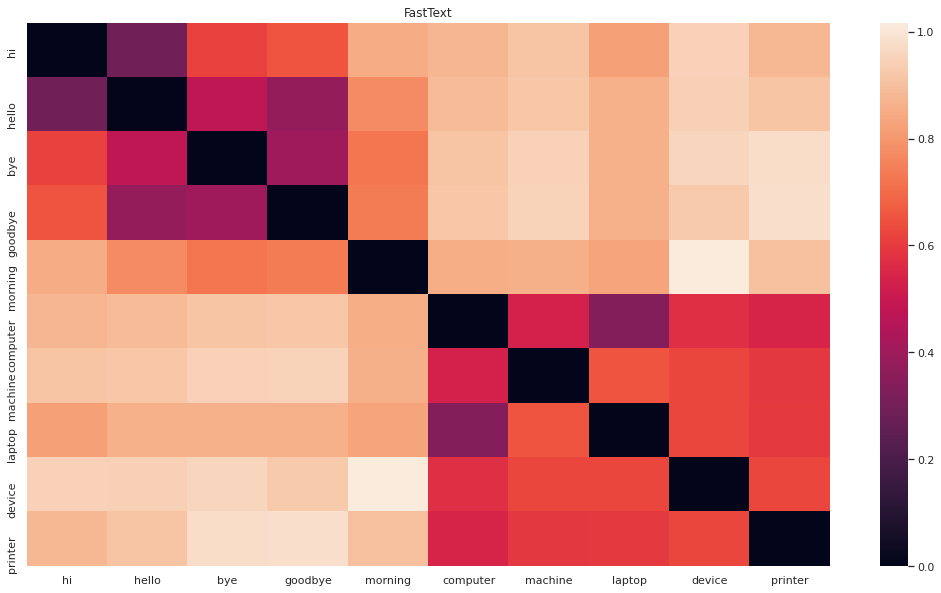

In [3]:
from scipy.spatial.distance import cdist
import numpy as np; np.random.seed(0)
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
uniform_data = np.random.rand(10, 12)

words = ['hi', 'hello', 'bye', 'goodbye', 'morning', 'computer', 'machine', 'laptop', 'device', 'printer']

A = model_ft.get_words_embeddings(words)
B = model_ft.get_words_embeddings(words)
dist = cdist(A,B,"cosine")
fig = plt.figure(figsize=(18,10))
ax = sns.heatmap(dist)
ax.set_xticklabels(words)
ax.set_yticklabels(words)
plt.title("FastText")
plt.show()

In [4]:
model_glove = GloveEmbeddings()
print(model_glove.get_words_embeddings(['hi', 'hello']))

[[ 5.8579e-01  8.0163e-02  1.9010e-01 -4.2974e-01 -6.7700e-01 -7.4183e-01
   2.3548e-01  5.6125e-01  3.4123e-02  6.6093e-01 -6.5666e-01 -3.1038e-01
  -3.3108e+00 -7.2266e-01 -1.8421e+00  9.9063e-01  2.6346e-02 -3.5894e-01
  -3.6259e-01  3.3939e-01  3.6955e-01  1.4748e-01 -4.5263e-01  3.8507e-01
  -5.6107e-01 -4.6079e-01  4.5029e-01 -4.5864e-02  8.2711e-01 -1.8816e-03
   4.5242e-01  6.7928e-01  7.2897e-01  6.7967e-02  3.0747e-01 -3.0777e-02
   1.4615e-01  9.8352e-01  3.0713e-01 -4.0797e-01 -1.6674e+00 -4.8884e-01
  -3.7614e-01  1.1126e+00 -8.0011e-01  2.9470e-01  2.1728e-01 -6.8735e-01
  -2.8111e-01  1.3931e-01]
 [ 2.8751e-01  3.1323e-01 -2.9318e-01  1.7199e-01 -6.9232e-01 -4.5930e-01
   1.3364e+00  7.0900e-01  1.2118e-01  1.1476e-01 -4.8505e-01 -8.8608e-02
  -3.0154e+00 -5.4024e-01 -1.3260e+00  3.9477e-01  1.1755e-01 -1.7816e-01
  -3.2272e-01  2.1715e-01  4.3144e-02 -4.3666e-01 -5.5857e-01 -4.7601e-01
  -9.5172e-02  3.1934e-03  1.1920e-01 -2.3643e-01  1.3234e+00 -4.5093e-01
  -6.5837e-

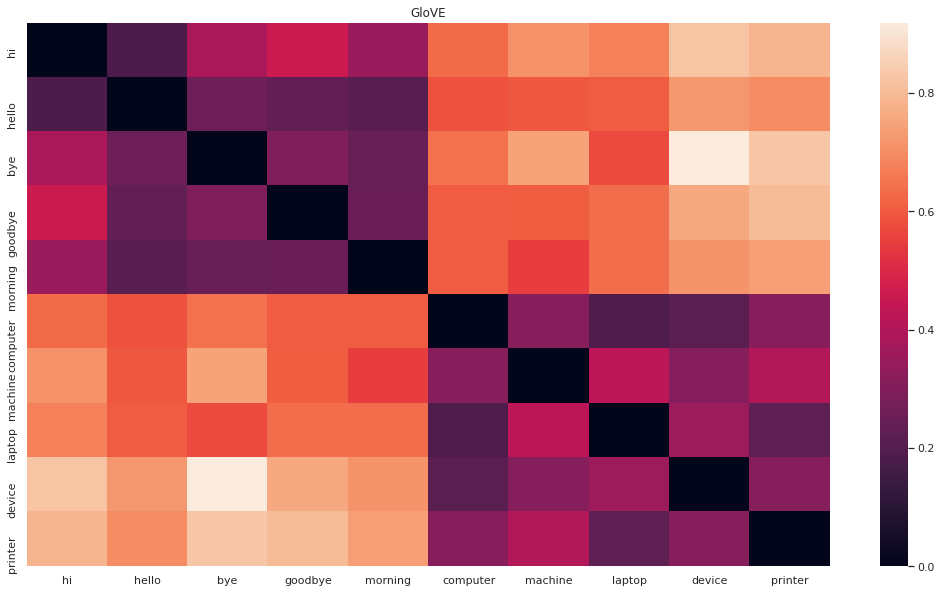

In [5]:
A = model_glove.get_words_embeddings(words)
B = model_glove.get_words_embeddings(words)
dist = cdist(A,B,"cosine")
fig = plt.figure(figsize=(18,10))
ax = sns.heatmap(dist)
ax.set_xticklabels(words)
ax.set_yticklabels(words)
plt.title("GloVE")
plt.show()